# Taylor Imhof
# Bellevue University | DSC 680
# Project One Notebook

In [1]:
# import required libraries
import pandas as pd
import numpy as np

# visualization packages
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('darkgrid')

## Loading the Cars Dataset

In [2]:
# read in cars data to pandas dataframe
df = pd.read_csv('data/cars.csv')
df.head()

,car_ID,symboling,CarName,fueltype,aspiration,doornumber,carbody,drivewheel,enginelocation,wheelbase,...,enginesize,fuelsystem,boreratio,stroke,compressionratio,horsepower,peakrpm,citympg,highwaympg,price
0,1,3,alfa-romero giulia,gas,std,two,convertible,rwd,front,88.6,...,130,mpfi,3.47,2.68,9.0,111,5000,21,27,13495.0
1,2,3,alfa-romero stelvio,gas,std,two,convertible,rwd,front,88.6,...,130,mpfi,3.47,2.68,9.0,111,5000,21,27,16500.0
2,3,1,alfa-romero Quadrifoglio,gas,std,two,hatchback,rwd,front,94.5,...,152,mpfi,2.68,3.47,9.0,154,5000,19,26,16500.0
3,4,2,audi 100 ls,gas,std,four,sedan,fwd,front,99.8,...,109,mpfi,3.19,3.40,10.0,102,5500,24,30,13950.0
4,5,2,audi 100ls,gas,std,four,sedan,4wd,front,99.4,...,136,mpfi,3.19,3.40,8.0,115,5500,18,22,17450.0


In [3]:
# view general dataset info
df.shape

(205, 26)

In [4]:
# view summary stats of the dataset
df.describe()

,car_ID,symboling,wheelbase,carlength,carwidth,carheight,curbweight,enginesize,boreratio,stroke,compressionratio,horsepower,peakrpm,citympg,highwaympg,price
count,205.000000,205.000000,205.000000,205.000000,205.000000,205.000000,205.000000,205.000000,205.000000,205.000000,205.000000,205.000000,205.000000,205.000000,205.000000,205.000000
mean,103.000000,0.834146,98.756585,174.049268,65.907805,53.724878,2555.565854,126.907317,3.329756,3.255415,10.142537,104.117073,5125.121951,25.219512,30.751220,13276.710571
std,59.322565,1.245307,6.021776,12.337289,2.145204,2.443522,520.680204,41.642693,0.270844,0.313597,3.972040,39.544167,476.985643,6.542142,6.886443,7988.852332
min,1.000000,-2.000000,86.600000,141.100000,60.300000,47.800000,1488.000000,61.000000,2.540000,2.070000,7.000000,48.000000,4150.000000,13.000000,16.000000,5118.000000
25%,52.000000,0.000000,94.500000,166.300000,64.100000,52.000000,2145.000000,97.000000,3.150000,3.110000,8.600000,70.000000,4800.000000,19.000000,25.000000,7788.000000
50%,103.000000,1.000000,97.000000,173.200000,65.500000,54.100000,2414.000000,120.000000,3.310000,3.290000,9.000000,95.000000,5200.000000,24.000000,30.000000,10295.000000
75%,154.000000,2.000000,102.400000,183.100000,66.900000,55.500000,2935.000000,141.000000,3.580000,3.410000,9.400000,116.000000,5500.000000,30.000000,34.000000,16503.000000
max,205.000000,3.000000,120.900000,208.100000,72.300000,59.800000,4066.000000,326.000000,3.940000,4.170000,23.000000,288.000000,6600.000000,49.000000,54.000000,45400.000000


This dataset is quite small, containing just over 200 observations with 26 features

In [5]:
df.dtypes

car_ID                int64
symboling             int64
CarName              object
fueltype             object
aspiration           object
doornumber           object
carbody              object
drivewheel           object
enginelocation       object
wheelbase           float64
carlength           float64
carwidth            float64
carheight           float64
curbweight            int64
enginetype           object
cylindernumber       object
enginesize            int64
fuelsystem           object
boreratio           float64
stroke              float64
compressionratio    float64
horsepower            int64
peakrpm               int64
citympg               int64
highwaympg            int64
price               float64
dtype: object

There appears to be a decent amount of both continuous and categorical variables that will be useful when training the prediction model. Based on some of the data types, there are some features that need to be converted to proper format for analysis purposes.

Time to take a deeper look at the data to see if any underlying trends can be uncovered

# Data Cleaning

In [5]:
# extract the first word from the car name feature
make = df['CarName'].apply(lambda x: x.split(' ')[0])

# insert new manufacturer into dataframe
df.insert(3, 'make', make)

# drop now redundant carname column from dataframe
# also drop other columns that are not useful like id and symboling columns
df.drop(columns=['car_ID', 'symboling', 'CarName'], axis=1, inplace=True)
df.head()

,make,fueltype,aspiration,doornumber,carbody,drivewheel,enginelocation,wheelbase,carlength,carwidth,...,enginesize,fuelsystem,boreratio,stroke,compressionratio,horsepower,peakrpm,citympg,highwaympg,price
0,alfa-romero,gas,std,two,convertible,rwd,front,88.6,168.8,64.1,...,130,mpfi,3.47,2.68,9.0,111,5000,21,27,13495.0
1,alfa-romero,gas,std,two,convertible,rwd,front,88.6,168.8,64.1,...,130,mpfi,3.47,2.68,9.0,111,5000,21,27,16500.0
2,alfa-romero,gas,std,two,hatchback,rwd,front,94.5,171.2,65.5,...,152,mpfi,2.68,3.47,9.0,154,5000,19,26,16500.0
3,audi,gas,std,four,sedan,fwd,front,99.8,176.6,66.2,...,109,mpfi,3.19,3.40,10.0,102,5500,24,30,13950.0
4,audi,gas,std,four,sedan,4wd,front,99.4,176.6,66.4,...,136,mpfi,3.19,3.40,8.0,115,5500,18,22,17450.0


In [6]:
# check how many unique manufacturers are contained in the dataset
df.make.unique()

array(['alfa-romero', 'audi', 'bmw', 'chevrolet', 'dodge', 'honda',
       'isuzu', 'jaguar', 'maxda', 'mazda', 'buick', 'mercury',
       'mitsubishi', 'Nissan', 'nissan', 'peugeot', 'plymouth', 'porsche',
       'porcshce', 'renault', 'saab', 'subaru', 'toyota', 'toyouta',
       'vokswagen', 'volkswagen', 'vw', 'volvo'], dtype=object)

There appear to be some typos in the dataset where the person encoding the data likely made a mistake during data entry.

To fix this, we will use a simply utility function to replace the typos with the correct spelling

In [7]:
# utility function that takes typo and replaces with correct spelling
def fix_typos(a, b):
    df.make.replace(a, b, inplace=True)

In [8]:
# normalize all make name by making them lowercase
df.make = df.make.str.lower()

# call fix typos function on all erroneous make names
fix_typos('maxda','mazda')
fix_typos('porcshce','porsche')
fix_typos('toyouta','toyota')
fix_typos('vokswagen','volkswagen')
fix_typos('vw','volkswagen')

In [9]:
# view unique values again to ensure there are no other typos
df.make.unique()

array(['alfa-romero', 'audi', 'bmw', 'chevrolet', 'dodge', 'honda',
       'isuzu', 'jaguar', 'mazda', 'buick', 'mercury', 'mitsubishi',
       'nissan', 'peugeot', 'plymouth', 'porsche', 'renault', 'saab',
       'subaru', 'toyota', 'volkswagen', 'volvo'], dtype=object)

In [10]:
# check for missing values
df.isnull().sum()

make                0
fueltype            0
aspiration          0
doornumber          0
carbody             0
drivewheel          0
enginelocation      0
wheelbase           0
carlength           0
carwidth            0
carheight           0
curbweight          0
enginetype          0
cylindernumber      0
enginesize          0
fuelsystem          0
boreratio           0
stroke              0
compressionratio    0
horsepower          0
peakrpm             0
citympg             0
highwaympg          0
price               0
dtype: int64

In [11]:
# check for duplicate values
df.duplicated().value_counts()

False    205
dtype: int64

Fortunately, for this dataset there does not appear to be any missing values

# Data Visualization

The first data point that I feel would be interesting to zone in on is the target or the price point that the cars have been sold at.

This feature is captured in the `price` column

C:\Users\taylo\anaconda3\envs\dsc650\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


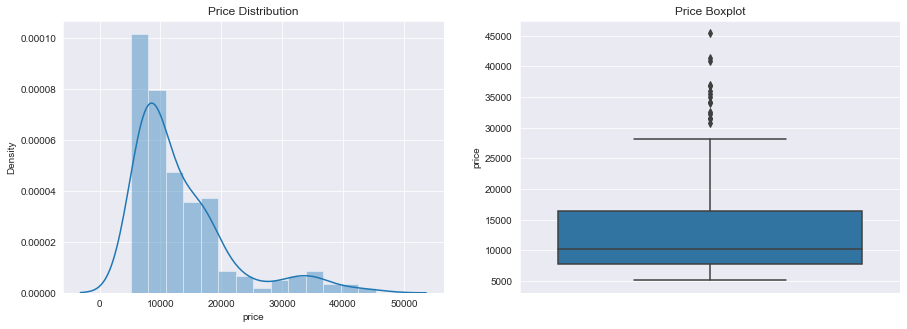

In [12]:
# plot feature column price [distribution plot and boxplot]
plt.figure(figsize=(15,5))

plt.subplot(1,2,1)
plt.title('Price Distribution')
sns.distplot(df.price)

plt.subplot(1,2,2)
plt.title('Price Boxplot')
sns.boxplot(y=df.price)

plt.show()

Based off the distribution plot of the `price` target column, the prices do appear to have a slight positive skew.

Looking at the boxplot, there do appear to be quite a few outliers on the high end, so perhaps performing a logarithmic transformation would be beneficial.

In [15]:
# create log transformation column on target column price
df['log_price'] = np.log1p(df['price'])
df['log_price'].head()

0    9.510149
1    9.711176
2    9.711176
3    9.543306
4    9.767152
Name: log_price, dtype: float64

C:\Users\taylo\anaconda3\envs\dsc650\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


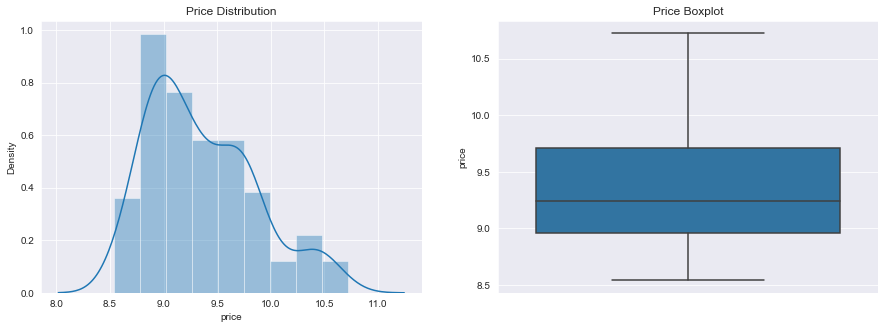

In [16]:
# re-plot dist and boxplot to see effects of log transformation
plt.figure(figsize=(15,5))

plt.subplot(1,2,1)
plt.title('Price Distribution')
sns.distplot(df.log_price)

plt.subplot(1,2,2)
plt.title('Price Boxplot')
sns.boxplot(y=df.log_price)

plt.show()

After performing the log transformation, the target data does appear to be more normally distributed, and the boxplot indicates that there are nearly zero outliers.

I plan on training the model using both with and without a transformed target to see if there are any effects to prediction performance.

There were quite a few categorical columns measured in this dataset. For model training purposes, in order to make these features more understandable to the machine, we will use an encoder. This is pretty standard for these types of problems.

In [17]:
# extract all categorical columns into separate dataframe
cat_cols = df.select_dtypes(exclude=['number'])
cat_cols.dtypes

make              object
fueltype          object
aspiration        object
doornumber        object
carbody           object
drivewheel        object
enginelocation    object
enginetype        object
cylindernumber    object
fuelsystem        object
dtype: object

In [18]:
# encode cat columns
from sklearn.preprocessing import LabelEncoder

# create new label encoder object
le = LabelEncoder()

# iterate across all cat columns in dataframe and encode to numeric value
for col in cat_cols:
    if col in df.columns:
        le.fit(list(df[col].astype(str).values))
        df[col] = le.transform(list(df[col].astype(str).values))

In [19]:
df.dtypes

make                  int32
fueltype              int32
aspiration            int32
doornumber            int32
carbody               int32
drivewheel            int32
enginelocation        int32
wheelbase           float64
carlength           float64
carwidth            float64
carheight           float64
curbweight            int64
enginetype            int32
cylindernumber        int32
enginesize            int64
fuelsystem            int32
boreratio           float64
stroke              float64
compressionratio    float64
horsepower            int64
peakrpm               int64
citympg               int64
highwaympg            int64
price               float64
log_price           float64
dtype: object

## Correlation Matrix

Correlation matrices are great at getting an understanding of how the underlying data relates, especially with regard to the target `price`

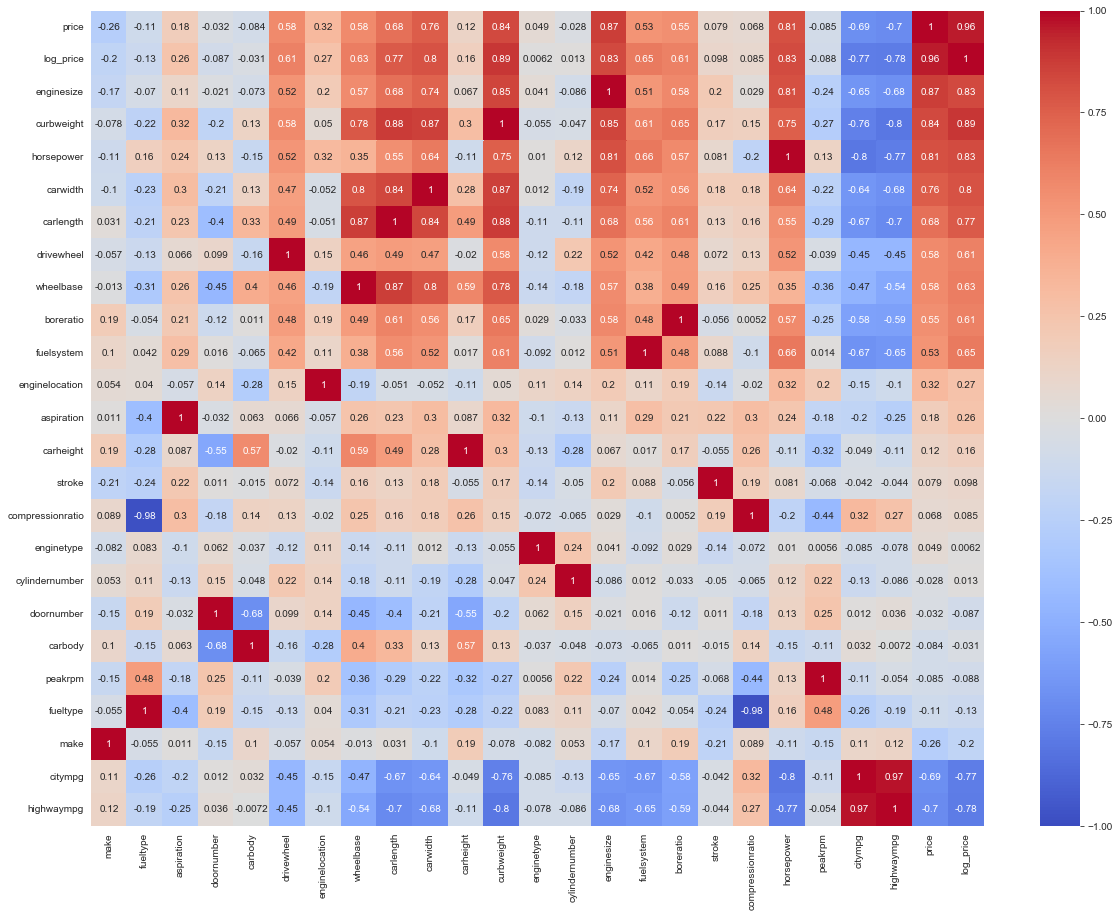

In [20]:
# sort corr matrix
plt.figure(figsize=(20,15))
sns.heatmap(df.corr().sort_values(by=['price'], ascending=False),
            annot=True, cmap='coolwarm', vmin=-1
            )

Heatmaps are great at getting an at-a-glance insight into potential features that might be good predictors for the target `price`

On the positive side, it would appear that the columns `enginesize`, `curbweight`, `carwidth`, and `horsepower` have a highly positive correlation with the target column.

On the negative side,  `highwaympg` and `citympg` are negatively correlated with the price target. This would indicate the as the selling price of the vehicle increases, the efficiency  of the vehicle decreases.

In a similar vein, these two features appear to be potentially multi-correlated, as they measure very similar information. As such, I will likely opt to select only one of them for model training purposes. Perhaps I could train the model with each one individually and measure performance to see which is more predictive.

## Scatterplots For Potentially Informative Features

Text(0.5, 1.0, 'Regplot: Price vs Horsepower')

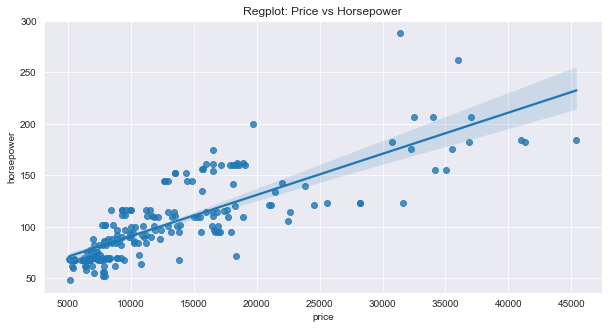

In [21]:
# scatter between horsepower and price
# used regplot to add additional fitted regression line
plt.figure(figsize=(10,5))
sns.regplot(data=df, x='price', y='horsepower')
plt.title('Regplot: Price vs Horsepower')

Text(0.5, 1.0, 'Regplot: LogPrice vs Horsepower')

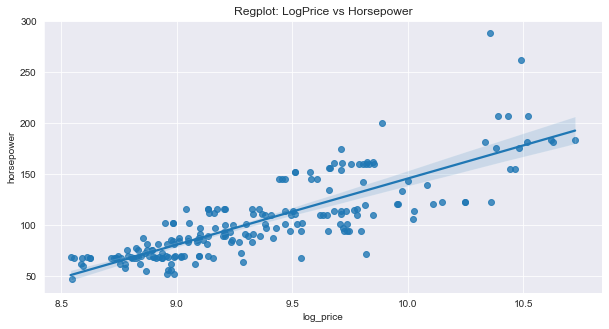

In [22]:
plt.figure(figsize=(10,5))
sns.regplot(data=df, x='log_price', y='horsepower')
plt.title('Regplot: LogPrice vs Horsepower')

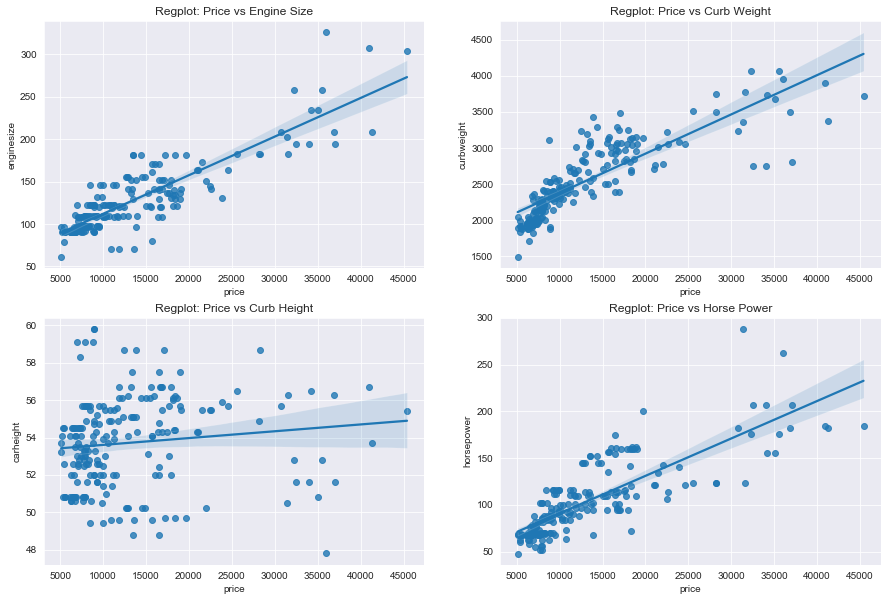

In [23]:
# display regplots for other possible explanatory variables
fix, axs = plt.subplots(2, 2, figsize=(15,10))

sns.regplot(data=df, x='price', y='enginesize', ax=axs[0,0])
sns.regplot(data=df, x='price', y='curbweight', ax=axs[0,1])
sns.regplot(data=df, x='price', y='carheight', ax=axs[1,0])
sns.regplot(data=df, x='price', y='horsepower', ax=axs[1,1])

axs[0,0].set_title('Regplot: Price vs Engine Size')
axs[0,1].set_title('Regplot: Price vs Curb Weight')
axs[1,0].set_title('Regplot: Price vs Curb Height')
axs[1,1].set_title('Regplot: Price vs Horse Power')

plt.show()

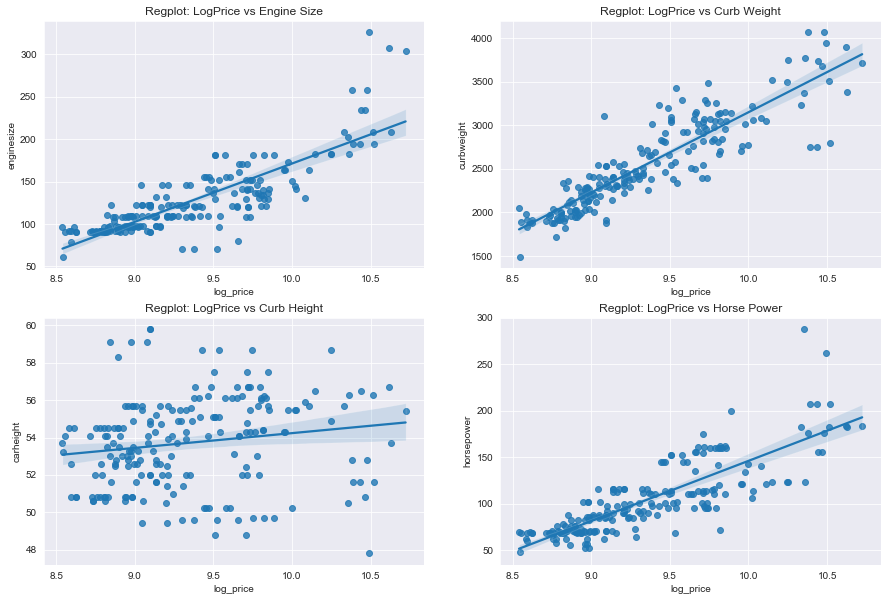

In [24]:
# display same plots but against logarithmic transformed price target
# display regplots for other possible explanatory variables
fix, axs = plt.subplots(2, 2, figsize=(15,10))

sns.regplot(data=df, x='log_price', y='enginesize', ax=axs[0,0])
sns.regplot(data=df, x='log_price', y='curbweight', ax=axs[0,1])
sns.regplot(data=df, x='log_price', y='carheight', ax=axs[1,0])
sns.regplot(data=df, x='log_price', y='horsepower', ax=axs[1,1])

axs[0,0].set_title('Regplot: LogPrice vs Engine Size')
axs[0,1].set_title('Regplot: LogPrice vs Curb Weight')
axs[1,0].set_title('Regplot: LogPrice vs Curb Height')
axs[1,1].set_title('Regplot: LogPrice vs Horse Power')

plt.show()

When comparing the regplots against the untransformed and transformed `price` target, the features seem to have a stronger linear relationship with the `log_price`.

For testing purposes, I do plan on training my models against both target to gauge their respective performances.

Taking a look at this scatterplot, the `horsepower` feature appears to have a linear correlation with the target `price`.

It should be noted that as the price increases, the horsepower feature seems to experience more variance.

## Data Pre-Processing

In [25]:
# convert floats to ints
float_cols = ["wheelbase","carlength","carwidth","carheight",
              "boreratio","stroke","compressionratio"]
df[float_cols] = df[float_cols].astype('int32')

df.dtypes

make                  int32
fueltype              int32
aspiration            int32
doornumber            int32
carbody               int32
drivewheel            int32
enginelocation        int32
wheelbase             int32
carlength             int32
carwidth              int32
carheight             int32
curbweight            int64
enginetype            int32
cylindernumber        int32
enginesize            int64
fuelsystem            int32
boreratio             int32
stroke                int32
compressionratio      int32
horsepower            int64
peakrpm               int64
citympg               int64
highwaympg            int64
price               float64
log_price           float64
dtype: object

In [28]:
# assign features and target to separate dataframes/index
X1 = df.drop(columns=['price', 'log_price'], axis=1)
y1 = df['price']

X2 = df.drop(columns=['price', 'log_price'], axis=1)
y2 = df['log_price']

In [37]:
print(X1.shape, X2.shape)
print(y1.shape, y2.shape)

(205, 23) (205, 23)
(205,) (205,)


In [39]:
y1.head(), y2.head()

(0    13495.0
 1    16500.0
 2    16500.0
 3    13950.0
 4    17450.0
 Name: price, dtype: float64,
 0    9.510149
 1    9.711176
 2    9.711176
 3    9.543306
 4    9.767152
 Name: log_price, dtype: float64)

# Model Training

In [40]:
# split data into train and test split
from sklearn.model_selection import train_test_split

X_train1, X_test1, y_train1, y_test1 = train_test_split(X1, y1, test_size=0.2, random_state=42)
X_train2, X_test2, y_train2, y_test2 = train_test_split(X2, y2, test_size=0.2, random_state=42)

# view shapes of new frames/indices
print(X_train1.shape)
print(y_train1.shape)
print(X_test1.shape)
print(y_test1.shape)

(164, 23)
(164,)
(41, 23)
(41,)


## Simple Linear Regression Model

In [43]:
from sklearn.linear_model import LinearRegression

# create new linear regression object
lr1 = LinearRegression()
lr2 = LinearRegression()

# fit lr model to train data
lr1.fit(X_train1, y_train1)
lr2.fit(X_train2, y_train2)

# view simple score of test data
print(lr1.score(X_test1, y_test1))
print(lr2.score(X_test2, y_test2))

0.8370703474602866
0.8909274154203741


Looks like the simple linear regression model achieved a score `coefficient of determination` of 0.81. Not too terrible, but keep in mind the training data was quite small.

Let's take a look at other model performance metrics

In [47]:
from sklearn.metrics import mean_squared_error, r2_score

# get predicts of trained model on test data
preds1 = lr1.predict(X_test1)
preds2 = lr2.predict(X_test2)

# display mean squared error and r2 score
print('MSE:', mean_squared_error(preds1, y_test1, squared=False))
print('R2:', r2_score(y_test1, preds1))

print('*' * 50)

print('Log MSE:', mean_squared_error(preds2, y_test2, squared=False))
print('Log R2:', r2_score(y_test2, preds2))

MSE: 3586.4079371999087
R2: 0.8370703474602866
**************************************************
Log MSE: 0.17201664272547257
Log R2: 0.8909274154203741


Reviewing these two scores, the linear model has performed with relatively high success.

The MSE value of 3803.73 indicates that the mean error of the predictions is off by about $4,000 dollars. When considering buying a used car, $4k is actually quite a bit of change.

The R-squared value indicates that the model can explain >80% of the variance in the entire data set. This metrics is a decent measure of goodness-of-fit.

Even though these metrics are decent, I feel that we can do better. Let us try using a different model and compare the performance metrics

## Decision Tree Regressor

In [49]:
from sklearn.tree import DecisionTreeRegressor

# create new decision tree regressor object
dtr1 = DecisionTreeRegressor(splitter='random')
dtr2 = DecisionTreeRegressor(splitter='random')

# fit to training data
dtr1.fit(X_train1, y_train1)
dtr2.fit(X_train2, y_train2)

# check r2 score
print(dtr1.score(X_test1, y_test1))
print(dtr2.score(X_test2, y_test2))

0.9191977518142423
0.849191861161625


In [50]:
# get predicts of trained model on test data
preds1 = dtr1.predict(X_test1)
preds2 = dtr2.predict(X_test2)

# display mean squared error and r2 score
print('MSE:', mean_squared_error(preds1, y_test1, squared=False))
print('R2:', r2_score(y_test1, preds1))

print('*' * 50)

print('Log MSE:', mean_squared_error(preds2, y_test2, squared=False))
print('Log R2:', r2_score(y_test2, preds2))

MSE: 2525.6393978356714
R2: 0.9191977518142423
**************************************************
Log MSE: 0.2022670102905879
Log R2: 0.849191861161625


Looking at the results of the Decision Tree Regressor, the model seems to have performed marginally better than the simple linear regression model.

Mean-square-error is not $3,680, which is still considerable when you are thinking of purchasing a used vehicle, especially for older more run-down vehicles.

The Decision Tree Regressor did achieve a slightly higher r2 score of approx 83% (explained variance).

Still, I think there is some room for improvement!

## K-Neighbors Regressor

In [85]:
from sklearn.neighbors import KNeighborsRegressor

# try a short range of different neighbor values and determine the one with best metrics
for i in range(1,10):
    print(f'**************************************\n{i}th iteration of KNR Model')

    # create new knr object
    knr = KNeighborsRegressor(n_neighbors=i)

    # fit knr to train data
    knr.fit(X_train1, y_train1)

    preds = knr.predict(X_test1)

    # display mean squared error
    print('MSE:', mean_squared_error(preds, y_test1, squared=False))
    print('R2:', r2_score(y_test1, preds))

**************************************
1th iteration of KNR Model
MSE: 3384.0252584174145
R2: 0.8549399077725732
**************************************
2th iteration of KNR Model
MSE: 4535.700470270219
R2: 0.7394029525380986
**************************************
3th iteration of KNR Model
MSE: 4118.894750573364
R2: 0.7850971640757605
**************************************
4th iteration of KNR Model
MSE: 4121.581736693359
R2: 0.7848166862676035
**************************************
5th iteration of KNR Model
MSE: 4229.495073986414
R2: 0.7734010963522522
**************************************
6th iteration of KNR Model
MSE: 4479.502081913027
R2: 0.7458206628155959
**************************************
7th iteration of KNR Model
MSE: 4484.386721064211
R2: 0.7452660247099359
**************************************
8th iteration of KNR Model
MSE: 4522.072969308219
R2: 0.7409665265097056
**************************************
9th iteration of KNR Model
MSE: 4551.5801423219855
R2: 0.7375750

After trying different values for `n`, it would appear that n=1 has the highest predictive power.

We are at least moving in the right direction. The MSE is down from $3.6k to $3.3k, though this is a considerable amount of money.

The r2 value also saw a slight increase, meaning that perhaps the K-neighbors Regressor is the best fitting model we have trained thus far.

Let's try to train one last model to see if we can achieve higher prediction performance.

## Random Forest Regressor

In [51]:
from sklearn.ensemble import RandomForestRegressor

# create new random forest regressor object
rfr1 = RandomForestRegressor()
rfr2 = RandomForestRegressor()

# fit model to train data
rfr1.fit(X_train1, y_train1)
rfr2.fit(X_train2, y_train2)

# make predictions
preds1 = rfr1.predict(X_test1)
preds2 = rfr2.predict(X_test2)

# display performance metrics
print('MSE:', mean_squared_error(preds1, y_test1, squared=False))
print('R2:', r2_score(y_test1, preds1))
print('*' * 25)
print('Log MSE:', mean_squared_error(preds2, y_test2, squared=False))
print('Log R2:', r2_score(y_test2, preds2))

MSE: 1844.7872490020063
R2: 0.9568904654695979
*************************
Log MSE: 0.11947444452838422
Log R2: 0.9473831663339484


There we go! That seems to be quite a bit better when compared with the previous models.

Still, an MSE of $1.8k is quite considerable when shopping for a used car. I do think this model could provide prospective car buyers with a slight edge in order to combat those greedy used-car salesman.

Interestingly, when comparing the results between model's training on the log price vs non-log price, only the simple linear regression saw an improvement in the r2 score (and just marginally at that). Perhaps there is a better approach to using the log transformed `price` target.